In [89]:
# import all packages and dependencies 

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_input_efficientnet


In [90]:
# set parameters

fpath = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train"
categories = os.listdir(fpath)
num_classes = len(categories)
seed=1234
validation_split=0.2
batch_size=32
labels="inferred"
label_mode="categorical"
input_shape=(256, 256, 3)
#learning_rate=1e-4
#epochs=100

In [91]:
# import training and test data

# train data
train_data_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/train"
images_train = image_dataset_from_directory(
    train_data_path,
    seed=seed,
    subset="both",
    validation_split=validation_split,
    batch_size=batch_size,
    labels=labels,
    label_mode=label_mode
)


# test data
test_data_path = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/test"
images_test = image_dataset_from_directory(
    test_data_path,
    seed=seed,
    subset=None,
    validation_split=None,
    batch_size=batch_size,
    labels=labels,
    label_mode=label_mode
)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.


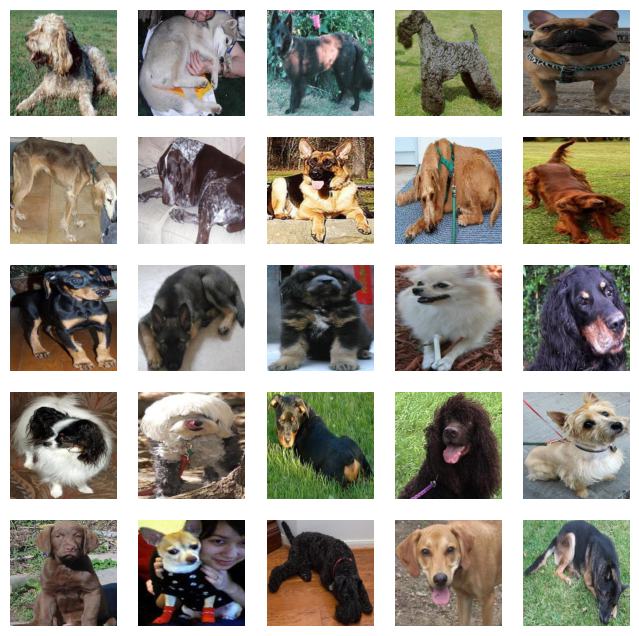

In [82]:
# see what you got in your training directory

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterate through the subplots and display random dog images
for indx, axis in enumerate(axes.flatten()):
    train_data_path_TEMP = random.choice(os.listdir(train_data_path))
    # Get a random index within the range of available images
    rnd_indx = np.random.randint(0, len(os.listdir(train_data_path+'/'+train_data_path_TEMP)))
    
    # Load and display the image using Matplotlib
    images = os.listdir(train_data_path+'/'+train_data_path_TEMP+'/')
    img = plt.imread(train_data_path+'/'+train_data_path_TEMP + '/'+images[rnd_indx])

    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Turn off the axis for better visualization

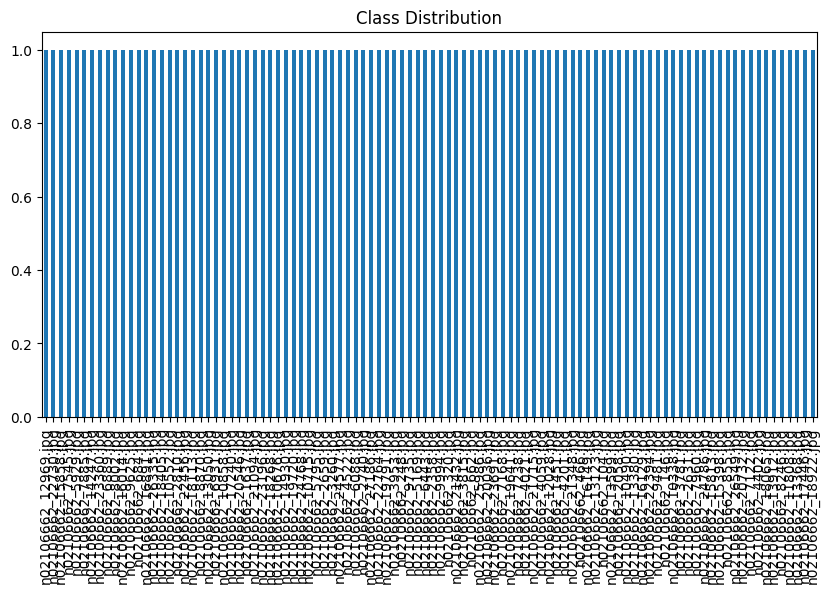

In [83]:
# Display distribution of classes

label_counts = pd.Series(images).value_counts()
label_counts.plot(kind='bar', figsize=(10,5), title="Class Distribution")
plt.show()

# Now, let's compare two models for baseline #

## 1) VGG16 model

In [92]:
# Preprocess training and validation data for VGG16 model

images_train_VGG16_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_vgg16(x), y))
images_val_VGG16_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_vgg16(x), y))

In [93]:
##############
# load model #
##############
def load_pretrained_model(input_shape=input_shape):
    """
    Load pre-trained VGG16 model and freeze pre-trained layers
    """
    vgg16_model = VGG16(weights="imagenet", 
                        include_top=False, 
                        input_shape=input_shape)
    vgg16_model.trainable = False
    return vgg16_model

###############
# build model #
###############
def build_model(base_model):
    """
    Build model
    """
    model = models.Sequential() # Instantiate the Sequential model
    model.add(base_model)
    model.add(layers.Flatten()) # Flattening layer
    model.add(layers.Dense(500, activation='relu')) # Hidden Dense layer
    model.add(layers.Dense(120, activation='softmax')) # Predictive layer, here 120 can be replaced with the num_classes parameter written above
    return model

#################
# compile model #
#################
def compile_model(model):
    """
    Compile model now
    """
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

###############
# train model #
###############
def train_model(model, train_data, val_data):
    """
    Train the model
    """
    es = callbacks.EarlyStopping(patience=3)
    history = model.fit(train_data,
                        epochs=100,
                        batch_size=batch_size,
                        callbacks=[es],
                        validation_data=val_data,
                        verbose=1)
    return history

In [106]:
vgg16_base_model = load_pretrained_model(input_shape)
custom_model = build_model(vgg16_base_model)
compiled_model = compile_model(custom_model)
history_vgg16 = train_model(compiled_model, images_train_VGG16_preproc, images_val_VGG16_preproc)

Epoch 1/100
300/300 [==============================] - 55s 160ms/step - loss: 14.9209 - accuracy: 0.0079 - val_loss: 4.7885 - val_accuracy: 0.0046
Epoch 2/100
300/300 [==============================] - 45s 150ms/step - loss: 4.8008 - accuracy: 0.0079 - val_loss: 4.7896 - val_accuracy: 0.0046
Epoch 3/100
300/300 [==============================] - 46s 152ms/step - loss: 4.7874 - accuracy: 0.0093 - val_loss: 4.7926 - val_accuracy: 0.0046
Epoch 4/100
300/300 [==============================] - 46s 151ms/step - loss: 4.7860 - accuracy: 0.0100 - val_loss: 4.7916 - val_accuracy: 0.0046


In [96]:
# Evaluate VGG16 model on validation set
vgg16_val_loss, vgg16_val_accuracy = compiled_model.evaluate(images_val_VGG16_preproc)
vgg16_val_accuracy

75/75 [==============================] - 13s 166ms/step - loss: 3.8181 - accuracy: 0.2912


0.29124999046325684

In [98]:
# Now evaluate VGG16 model on Test data

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_vgg16 = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_vgg16}")

evaluate_model(compiled_model, images_test)

269/269 [==============================] - 46s 169ms/step - loss: 6.6321 - accuracy: 0.1355
Test Loss: 6.632081031799316
Test Accuracy: 0.13554778695106506


## 2) Densenet121 model

In [107]:
# Preprocess training and validation data for DenseNet121 model

images_train_dense_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_densenet(x), y))
images_val_dense_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_densenet(x), y))

In [108]:
# Load pre-trained DenseNet121 model with specified input shape

def load_pretrained_model(input_shape=input_shape):
    dense121_model = DenseNet121(weights="imagenet", 
                                 include_top=False, 
                                 input_shape=input_shape)
    dense121_model.trainable = False
    return dense121_model


In [102]:
# use training data

dense121_base_model = load_pretrained_model(input_shape)
custom_model = build_model(dense121_base_model)
compiled_model = compile_model(custom_model)
history_dense121 = train_model(compiled_model, images_train_dense_preproc, images_val_dense_preproc)

Epoch 1/100
300/300 [==============================] - 55s 157ms/step - loss: 4.4545 - accuracy: 0.3494 - val_loss: 1.5878 - val_accuracy: 0.5804
Epoch 2/100
300/300 [==============================] - 46s 153ms/step - loss: 0.7536 - accuracy: 0.7732 - val_loss: 1.3495 - val_accuracy: 0.6546
Epoch 3/100
300/300 [==============================] - 46s 151ms/step - loss: 0.3020 - accuracy: 0.9008 - val_loss: 1.3306 - val_accuracy: 0.6712
Epoch 4/100
300/300 [==============================] - 46s 152ms/step - loss: 0.1810 - accuracy: 0.9383 - val_loss: 1.3038 - val_accuracy: 0.6792
Epoch 5/100
300/300 [==============================] - 46s 152ms/step - loss: 0.1363 - accuracy: 0.9535 - val_loss: 1.4902 - val_accuracy: 0.6963
Epoch 6/100
300/300 [==============================] - 46s 152ms/step - loss: 0.2056 - accuracy: 0.9340 - val_loss: 1.9292 - val_accuracy: 0.6562
Epoch 7/100
300/300 [==============================] - 46s 152ms/step - loss: 0.2580 - accuracy: 0.9245 - val_loss: 2.1369 -

In [104]:
# Evaluate DenseNet121 model on validation set
densenet121_val_loss, densenet121_val_accuracy = compiled_model.evaluate(images_val_dense_preproc)
densenet121_val_accuracy

75/75 [==============================] - 9s 113ms/step - loss: 2.1369 - accuracy: 0.6575


0.6575000286102295

In [105]:
# Now evaluate Densenet121 model on Test data

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_densenet = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_densenet}")

evaluate_model(compiled_model, images_test)

269/269 [==============================] - 31s 114ms/step - loss: 71.4791 - accuracy: 0.0073
Test Loss: 71.47914123535156
Test Accuracy: 0.0073426575399935246


## 3) EfficientNetB7 model

In [109]:
# Preprocess training and validation data for EfficientNetB7

images_train_efficient_preproc = images_train[0].map(
  lambda x, y: (preprocess_input_efficientnet(x), y))
images_val_efficient_preproc = images_train[1].map(
  lambda x, y: (preprocess_input_efficientnet(x), y))

In [110]:
from tensorflow.keras.applications import EfficientNetB7

# Load pre-trained EfficientNetB7 model with specified input shape
def load_pretrained_model(input_shape=input_shape):
    efficientnetb7_model = EfficientNetB7(weights="imagenet", 
                                          include_top=False, 
                                          input_shape=input_shape)
    efficientnetb7_model.trainable = False
    return efficientnetb7_model

In [111]:
efficientnetb7_base_model = load_pretrained_model(input_shape)
custom_model = build_model(efficientnetb7_base_model)
compiled_model = compile_model(custom_model)
history_efficientnetb7 = train_model(compiled_model, images_train_efficient_preproc, images_val_efficient_preproc)

Epoch 1/100


2024-02-07 17:35:15.969498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


300/300 [==============================] - 211s 618ms/step - loss: 3.6362 - accuracy: 0.6421 - val_loss: 0.9901 - val_accuracy: 0.8054
Epoch 2/100
300/300 [==============================] - 179s 597ms/step - loss: 0.6395 - accuracy: 0.8625 - val_loss: 0.9504 - val_accuracy: 0.8213
Epoch 3/100
300/300 [==============================] - 179s 597ms/step - loss: 0.5021 - accuracy: 0.8900 - val_loss: 0.9294 - val_accuracy: 0.8371
Epoch 4/100
300/300 [==============================] - 179s 597ms/step - loss: 0.4262 - accuracy: 0.9194 - val_loss: 1.3142 - val_accuracy: 0.8229
Epoch 5/100
300/300 [==============================] - 179s 596ms/step - loss: 0.4836 - accuracy: 0.9116 - val_loss: 1.3409 - val_accuracy: 0.8304
Epoch 6/100
300/300 [==============================] - 179s 597ms/step - loss: 0.4232 - accuracy: 0.9235 - val_loss: 1.3469 - val_accuracy: 0.8388


In [113]:
# Evaluate EfficientNetB7 model on validation set
efficientnetb7_val_loss, efficientnetb7_val_accuracy = compiled_model.evaluate(images_val_efficient_preproc)
efficientnetb7_val_accuracy

75/75 [==============================] - 33s 440ms/step - loss: 1.3469 - accuracy: 0.8388


0.8387500047683716

In [114]:
# Now evaluate EfficientNetB7 model on Test data

def evaluate_model(model, test_data):
    """
    Evaluate on test data
    """
    loss, accuracy_efficientnet = model.evaluate(test_data)
    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy_efficientnet}")

evaluate_model(compiled_model, images_test)

269/269 [==============================] - 120s 446ms/step - loss: 1.4137 - accuracy: 0.8421
Test Loss: 1.4137451648712158
Test Accuracy: 0.8420745730400085


In [115]:
def plot_loss_accuracy(history):

    with plt.style.context('seaborn-deep'):

        fig, ax = plt.subplots(1, 2, figsize=(15, 4))

        ## Plot Losses and Accuracies
        x_axis = np.arange(len(history.history['loss']))

        ax[0].set_title("Loss")
        ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
        ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

        ax[1].set_title("Accuracy")
        ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
        ax[1].plot(x_axis,
                   history.history['val_accuracy'],
                   color="orange",
                   linestyle="-",
                   marker="X",
                   label="Val Accuracy")

        ## Customization
        ax[0].grid(axis="x", linewidth=0.5)
        ax[0].grid(axis="y", linewidth=0.5)
        ax[0].legend()

        ax[1].grid(axis="x", linewidth=0.5)
        ax[1].grid(axis="y", linewidth=0.5)
        ax[1].legend()


        plt.show()

Graphs for VGG16 pre-trained model


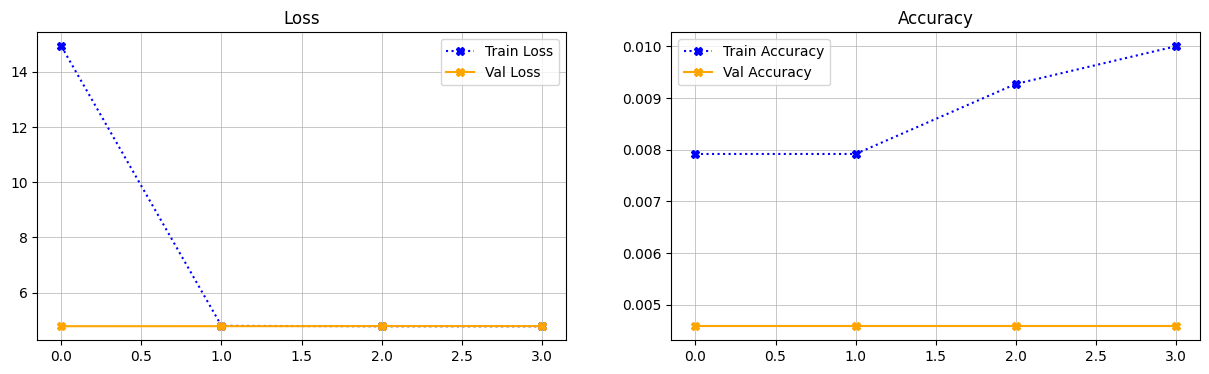

Graphs for DenseNet121 pre-trained model


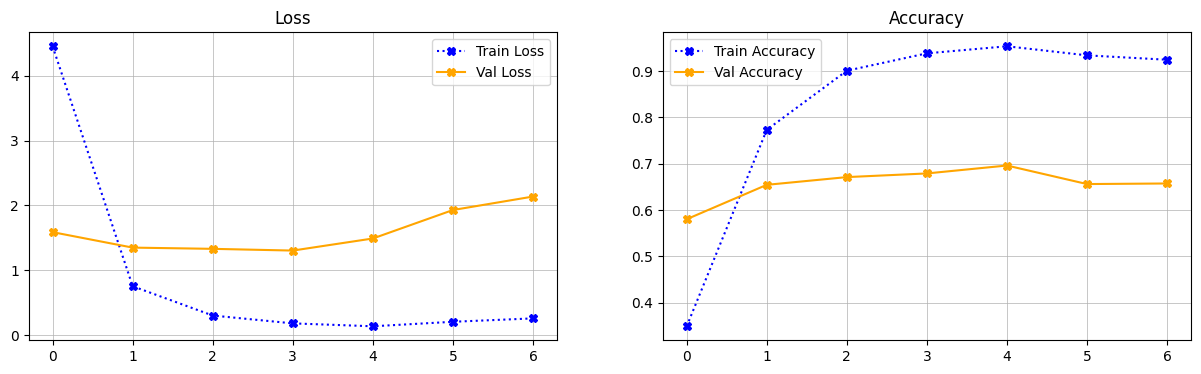

Graphs for EfficientNetB7 pre-trained model


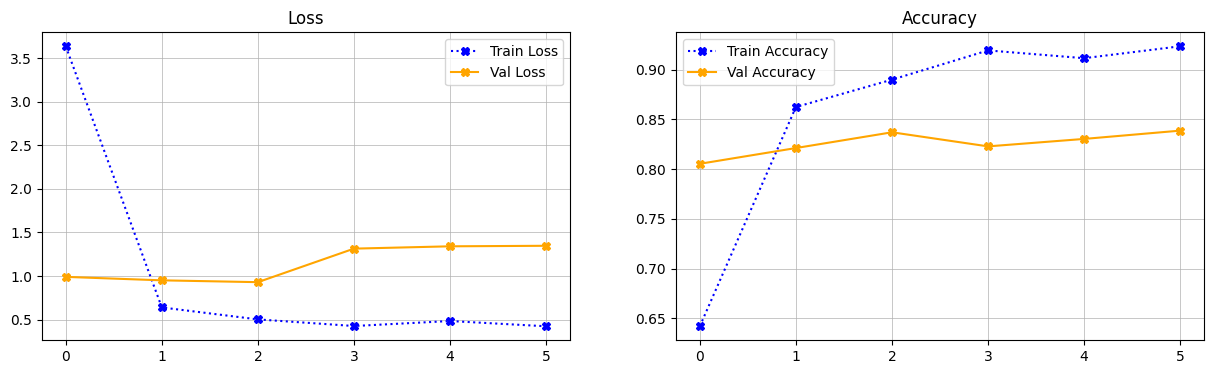

In [116]:
print("Graphs for VGG16 pre-trained model")
plot_loss_accuracy(history_vgg16)

print("Graphs for DenseNet121 pre-trained model")
plot_loss_accuracy(history_dense121)

print("Graphs for EfficientNetB7 pre-trained model")
plot_loss_accuracy(history_efficientnetb7)

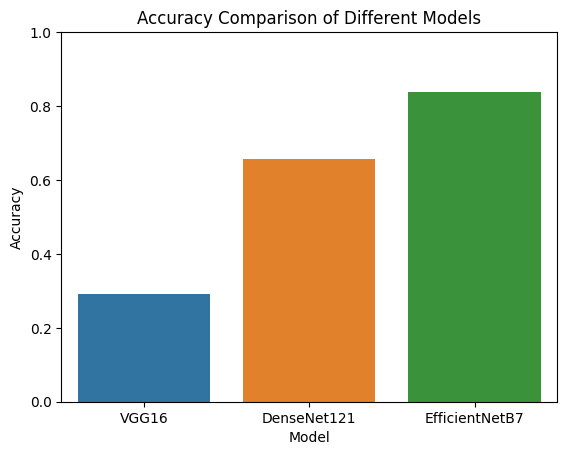

In [117]:
# Put all accuracies at one place
acc_vgg16 = vgg16_val_accuracy
acc_densenet121 = densenet121_val_accuracy
acc_efficientnetb7 = efficientnetb7_val_accuracy

# Create a DataFrame to store the accuracy data
data = pd.DataFrame({
    'Model': ['VGG16', 'DenseNet121', 'EfficientNetB7'],
    'Accuracy': [acc_vgg16, acc_densenet121, acc_efficientnetb7]
})

# Plot the accuracies using Seaborn
sns.barplot(x='Model', y='Accuracy', data=data)
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 (assuming accuracy is in the range 0-1)
plt.show()